In [2]:
# Import library
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy as sp
import splitfolders
from PIL import Image, ImageOps
from sklearn.metrics import classification_report, confusion_matrix
import random
import cv2
import zipfile, os

# Import deep learning library
import tensorflow as tf
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Section 1

### Import dataset from kaggle

In [ ]:
## Import data
!kaggle datasets download -d drgfreeman/rockpaperscissors

In [4]:
local_zip = 'rockpaperscissors.zip'
zip_extract = zipfile.ZipFile(local_zip, 'r')
zip_extract.extractall('/content')
zip_extract.close()

In [5]:
splitfolders.ratio('/content/rps-cv-images', output="/content/rockpaperscissors/", seed=1337, ratio=(.7, .3))
splitfolders.fixed('/content/rps-cv-images', output="/content/rockpaperscissors/", seed=1337, fixed=(100, 100))

data_dir = '/content/rockpaperscissors/'
training_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'val')

print("\n")
print("Total paper images : ", len(os.listdir('/content/paper')))
print("Total rock images : ", len(os.listdir('/content/rock')))
print("Total scissors images: ", len(os.listdir('/content/scissors')))

os.listdir('/content/rockpaperscissors/train')
os.listdir('/content/rockpaperscissors/val')
os.listdir('/content/rockpaperscissors/test')

Copying files: 2188 files [00:00, 4433.52 files/s]
Copying files: 2188 files [00:00, 2190.88 files/s]



Total paper images :  712
Total rock images :  726
Total scissors images:  750


['scissors', 'rock', 'paper']

In [37]:
training_paper_dir = os.path.join(training_dir, 'paper')
training_rock_dir = os.path.join(training_dir, 'rock')
training_scissors_dir = os.path.join(training_dir, 'scissors')

validation_paper_dir = os.path.join(validation_dir, 'paper')
validation_rock_dir = os.path.join(validation_dir, 'rock')
validation_scissors_dir = os.path.join(validation_dir, 'scissors')

paper_imgs = os.listdir(training_paper_dir)
rock_imgs = os.listdir(training_rock_dir)
scissors_imgs = os.listdir(training_scissors_dir)

## Section 2

### Plot random images from dataset to understand the data

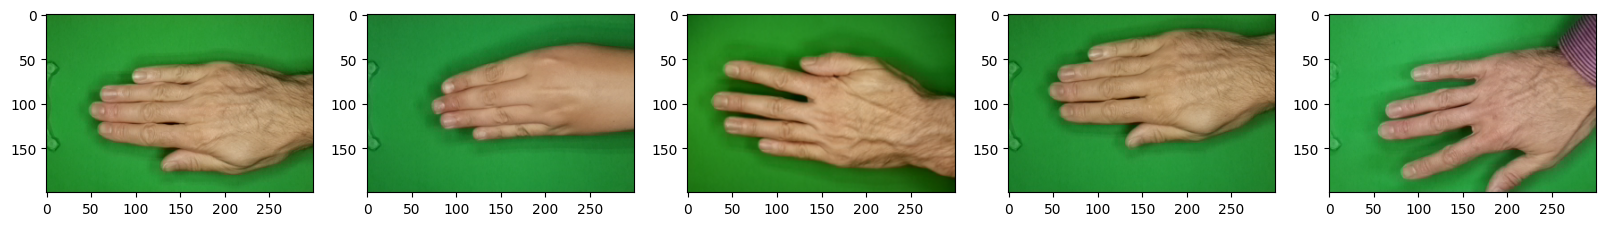

In [ ]:
plt.figure(figsize=(20, 4))
for i, img_path in enumerate(paper_imgs[:5]):
    sp = plt.subplot(1, 5, i+1)
    img = mpimg.imread(os.path.join(training_paper_dir, img_path))
    plt.imshow(img)
plt.show()

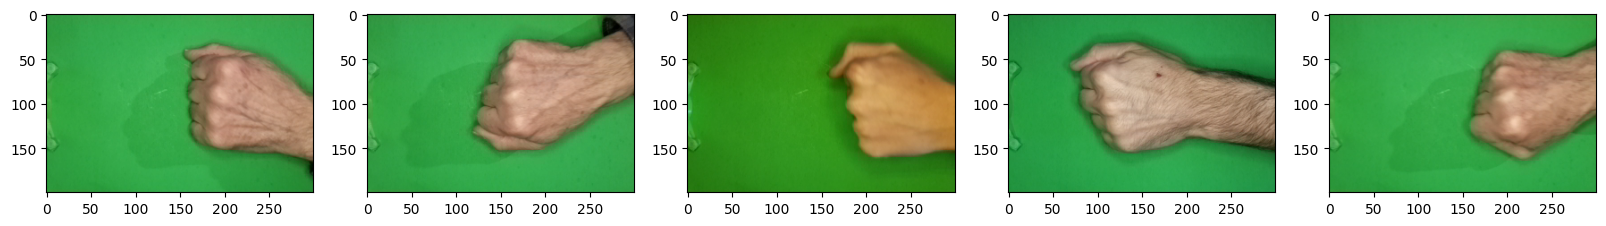

In [ ]:
plt.figure(figsize=(20, 4))
for i, img_path in enumerate(rock_imgs[:5]):
    sp = plt.subplot(1, 5, i+1)
    img = mpimg.imread(os.path.join(training_rock_dir, img_path))
    plt.imshow(img)
plt.show()

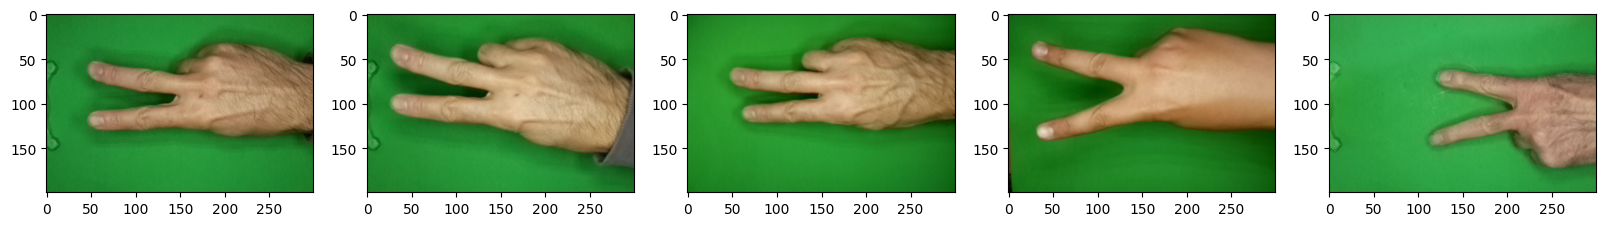

In [ ]:
plt.figure(figsize=(20, 4))
for i, img_path in enumerate(scissors_imgs[:5]):
    sp = plt.subplot(1, 5, i+1)
    img = mpimg.imread(os.path.join(training_scissors_dir, img_path))
    plt.imshow(img)
plt.show()

## Section 3

### Data augmentation

In [8]:
train_datagen = ImageDataGenerator(
                rescale=1./255,
                rotation_range=20,
                horizontal_flip=True,
                vertical_flip=True,
                shear_range = 0.2,
                validation_split=0.5)

validation_datagen = ImageDataGenerator(rescale = 1.0/255,
                                        validation_split=0.5)

train_generator = train_datagen.flow_from_directory(
        training_dir,
        target_size=(100,100),
        batch_size=32,
        class_mode='categorical',
        subset='training',
        color_mode="grayscale",
        shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(100,100),
        batch_size=32,
        class_mode='categorical',
        subset='validation',
        color_mode="grayscale",
        shuffle=True
)

Found 794 images belonging to 3 classes.
Found 328 images belonging to 3 classes.


In [ ]:
train_generator.class_indices

{'paper': 0, 'rock': 1, 'scissors': 2}

In [ ]:
validation_generator.class_indices

{'paper': 0, 'rock': 1, 'scissors': 2}

In [13]:
NUM_TRAIN_DATA = train_generator.n
NUM_VALID_DATA = validation_generator.n

## Sction 4

### The CNN model

In [9]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, kernel_size=3, activation='relu', input_shape=(100, 100, 1)),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 49, 49, 16)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 49, 49, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 23, 23, 32)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 23, 23, 32)        0

In [10]:
BATCH_SIZE = 32
EPOCHS = 20

### Training the model

In [11]:
model.compile(optimizer = 'RMSprop',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [31]:
history = model.fit(train_generator,
          steps_per_epoch=NUM_TRAIN_DATA // BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=validation_generator,
          validation_steps=5,
          verbose=2)

Epoch 1/20
24/24 - 4s - loss: 0.1322 - accuracy: 0.9606 - val_loss: 0.2729 - val_accuracy: 0.9500 - 4s/epoch - 172ms/step
Epoch 2/20
24/24 - 3s - loss: 0.1308 - accuracy: 0.9501 - val_loss: 0.1924 - val_accuracy: 0.9625 - 3s/epoch - 113ms/step
Epoch 3/20
24/24 - 3s - loss: 0.1174 - accuracy: 0.9567 - val_loss: 0.1727 - val_accuracy: 0.9563 - 3s/epoch - 110ms/step
Epoch 4/20
24/24 - 3s - loss: 0.1156 - accuracy: 0.9593 - val_loss: 0.1980 - val_accuracy: 0.9563 - 3s/epoch - 120ms/step
Epoch 5/20
24/24 - 4s - loss: 0.1139 - accuracy: 0.9724 - val_loss: 0.1649 - val_accuracy: 0.9375 - 4s/epoch - 159ms/step
Epoch 6/20
24/24 - 3s - loss: 0.1051 - accuracy: 0.9698 - val_loss: 0.1102 - val_accuracy: 0.9500 - 3s/epoch - 110ms/step
Epoch 7/20
24/24 - 3s - loss: 0.0836 - accuracy: 0.9751 - val_loss: 0.2351 - val_accuracy: 0.9625 - 3s/epoch - 115ms/step
Epoch 8/20
24/24 - 4s - loss: 0.1152 - accuracy: 0.9646 - val_loss: 0.1414 - val_accuracy: 0.9625 - 4s/epoch - 154ms/step
Epoch 9/20
24/24 - 3s - 

### Plotting the performance and loss

In [33]:
# Evaluate the performance of our CNN model with accuracy and loss plots

def eval_plot(history):

  plt.figure(figsize=(14, 5))

  # Accuracy plot
  plt.subplot(1, 2, 1)
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  epochs = range(len(acc))
  acc_plot, = plt.plot(epochs, acc, 'r')
  val_acc_plot, = plt.plot(epochs, val_acc, 'b')
  plt.title('Training and Validation Accuracy')
  plt.legend([acc_plot, val_acc_plot], ['Training Accuracy', 'Validation Accuracy'])

  # Loss plot
  plt.subplot(1, 2, 2)
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(loss))
  loss_plot, = plt.plot(epochs, loss, 'r')
  val_loss_plot, = plt.plot(epochs, val_loss, 'b')
  plt.title('Training and Validation Loss')
  plt.legend([loss_plot, val_loss_plot], ['Training Loss', 'Validation Loss'])

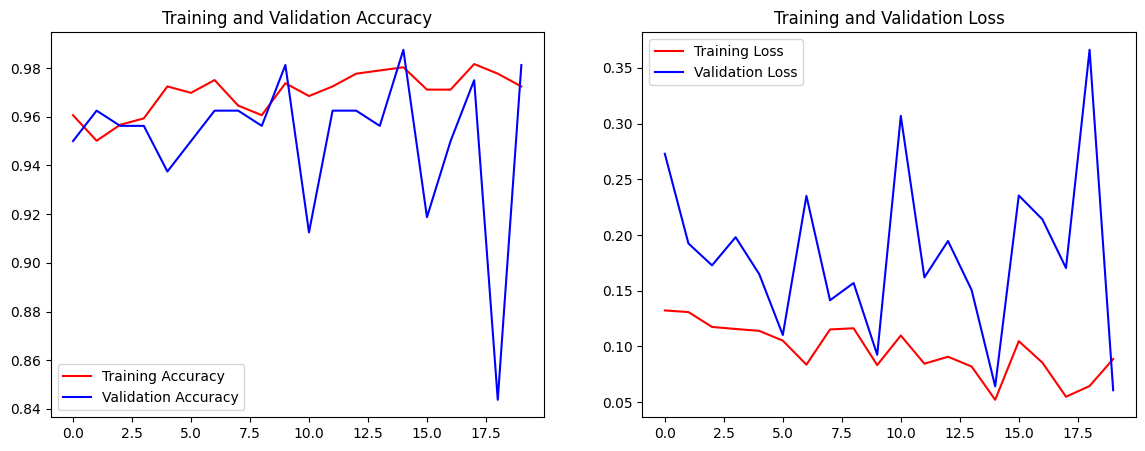

In [34]:
eval_plot(history)

In [35]:
def evaluate(model):

  validation_generator = train_datagen.flow_from_directory(
          training_dir,
          target_size=(100,100),
          batch_size=32,
          class_mode='categorical',
          color_mode="grayscale",
          shuffle = False,
          subset='validation')

  batch_size = 32
  num_of_test_samples = len(validation_generator.filenames)

  Y_pred = model.predict_generator(validation_generator, num_of_test_samples // batch_size+1)
  y_pred = np.argmax(Y_pred, axis=1)

  print('\nConfusion Matrix\n')
  print(confusion_matrix(validation_generator.classes, y_pred))


  print('\n\nClassification Report\n')
  target_names = ['Rock', 'Paper', 'Scissors']
  print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

In [36]:
evaluate(model)

Found 794 images belonging to 3 classes.

Confusion Matrix

[[244   9   3]
 [  2 261   0]
 [  9   1 265]]


Classification Report

              precision    recall  f1-score   support

        Rock       0.96      0.95      0.95       256
       Paper       0.96      0.99      0.98       263
    Scissors       0.99      0.96      0.98       275

    accuracy                           0.97       794
   macro avg       0.97      0.97      0.97       794
weighted avg       0.97      0.97      0.97       794



We have evaluated the accuracy of our model and it is 97% accurate on its predictions.

## Section 5

### The rock-paper-scissors application

In [19]:
class RPSGame:
    def __init__(self, rounds):
        self.rounds = rounds
        self.total_rounds = rounds
        self.actions = {'rock': 0, 'scissors': 1, 'paper': 2}
        self.score = {'player': 0, 'random_agent': 0}
        self.round_outcomes = []

    def plot_player_scores(self, player_scores: int):
      player_wins = [sum(self.round_outcomes[:i+1]) for i in range(len(self.round_outcomes))]
      rounds = list(range(1, len(player_wins) + 1))

      plt.plot(rounds, player_wins , marker='o', linestyle='-', color='b')
      plt.title('Agent Performance Over rounds')
      plt.xlabel('Rounds')
      plt.ylabel('Total wins')
      plt.show()

    def generate_random_agent_move(self):
      action, value =  random.choice(list(self.actions.items()))
      return action

    def pick_random_image(self, random_agent_action):
      category_folder = os.path.join(training_dir, random_agent_action)

      # get a list of files inside the category folder
      files = os.listdir(category_folder)

      return os.path.join(category_folder, random.choice(files))

    def preprocess_image(self, image_path):
      original_image = Image.open(image_path)

      # apply horizontal flip with 50% chance
      if random.random() < 0.5:
        original_image = ImageOps.mirror(original_image)

      # apply vertical flip with 50% chance
      if random.random() < 0.5:
        original_image = ImageOps.flip(original_image)

      # Convert the image to a NumPy array for adding gaussian noise
      image_array = np.array(original_image)

      # Add noise
      noise = np.random.normal(0, 12.75, image_array.shape)

      noisy_image_array = image_array + noise

      # Convert the noisy image array back to a PIL image
      return Image.fromarray(noisy_image_array.astype('uint8'), 'RGB')

    def determine_winner(self, player_move, random_agent_move):
      # Determine the winner based on the classic Rock, Paper, Scissors rules
      if (player_move == 'rock' and random_agent_move == 'scissors') or \
        (player_move == 'paper' and random_agent_move == 'rock') or \
        (player_move == 'scissors' and random_agent_move == 'paper'):
        return 'player'
      elif (random_agent_move == 'rock' and player_move == 'scissors') or \
          (random_agent_move == 'paper' and player_move == 'rock') or \
          (random_agent_move == 'scissors' and player_move == 'paper'):
        return 'random_agent'
      else:
        return 'tie'

    def our_agent_move(self, image_to_recognize, model = model):
      img = image_to_recognize.resize((100, 100))
      img_array = np.asarray(img) * (1/255)
      img_array = tf.reshape(img_array, shape = [-1, 100, 100, 1])

      predict_class = np.argmax(model.predict(img_array))

      if predict_class == 0:
        predict_label = 'paper'
        player_move = 'scissors'
      elif predict_class == 1:
        predict_label = 'rock'
        player_move = 'paper'
      else:
        predict_label = 'scissors'
        player_move = 'rock'

      return player_move

    def start_game(self):
      while self.rounds > 0:
        random_agent_action = self.generate_random_agent_move()

        # Add noise on random image
        noisy_image = self.preprocess_image(self.pick_random_image(random_agent_action))
        player_move = self.our_agent_move(noisy_image)
        winner = self.determine_winner(player_move, random_agent_action)

        # Update the score
        if winner == 'player':
            self.score['player'] += 1
            self.round_outcomes.append(1)
        elif winner == 'random_agent':
            self.score['random_agent'] += 1
            self.score['player'] -= 1
            self.round_outcomes.append(-1)

        self.rounds -= 1

      self.plot_player_scores(self.score['player'])


1/1 [==============================] - 0s 27ms/step


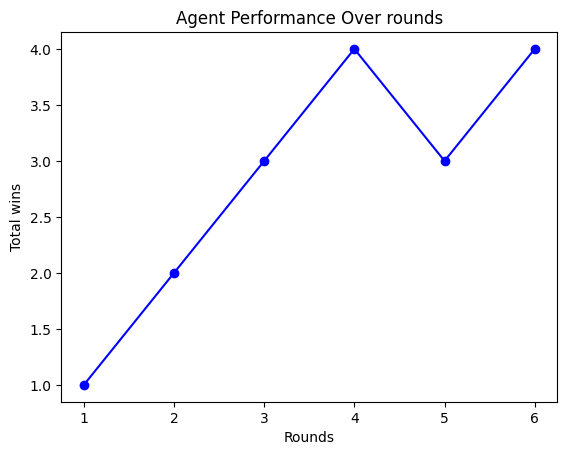

In [23]:
if __name__ == "__main__":
    # Create an instance of the game and run it
    game = RPSGame(rounds= 10)
    game.start_game()

## Section 6

### Check the accuracy on images that do not exist in the dataset

In [24]:
def predict_image(image_upload, model = model):
  img_array = np.asarray(image_upload) * (1/255)
  im_input = tf.reshape(img_array, shape = [-1, 100, 100, 1])

  predict_class = np.argmax(model.predict(im_input))
  predict_proba = sorted(model.predict(im_input)[0])[2]

  if predict_class == 0:
      predict_label = 'Paper'
  elif predict_class == 1:
      predict_label = 'Rock'
  else:
      predict_label = 'Scissor'

  print('\n')
  plt.show()
  print("\nImage prediction result: ", predict_label)
  print("Probability: ", round(predict_proba*100,2), "%")
  print('\n')

Saving rock-paper-scissors-img.png to rock-paper-scissors-img (5).png
1/1 [==============================] - 0s 30ms/step




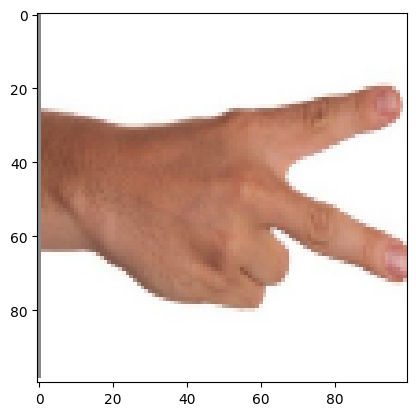


Image prediction result:  Scissor
Probability:  91.06 %




In [32]:
from google.colab import files
from keras.preprocessing import image
%matplotlib inline

uploaded = files.upload()

for filePath in uploaded.keys():
  img = image.load_img(filePath, target_size=(100,100))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  img = np.vstack([x])

  predict_image(img)